<h3>ANLY 601 Spring 2020 Project: Image Classification Optimization</h3>

<H3>Mengzhi Zhou, Guanzhi Wang</H3>

#### Imported Package 

In [1]:
#library package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tensorflow.keras.preprocessing import image
from zipfile import ZipFile 
import datetime
import time
import matplotlib.image as img


#deep learning model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import roc_auc_score
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras import layers, models, optimizers



c:\users\user\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\user\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\user\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\user\anaconda3\envs\tensorflow\lib\site-packages\ten

### EDA

Dataset: Dog vs. Cat

In [2]:
#load data
#dataset directory
test="dataset/test_set"
train="dataset/training_set"

#cat vs. dog
train_cats=train + '/cats'
train_dogs=train + '/dogs'
test_cats=test + '/cats'
test_dogs=test + '/dogs'

In [3]:
#basic info for dataset
print('cat (training):',len(os.listdir(train_cats)))
print('cat (testing):',len(os.listdir(test_cats)))
print('dog (training):',len(os.listdir(train_dogs)))
print('dog (testing):',len(os.listdir(test_dogs)))

cat (training): 7000
cat (testing): 3000
dog (training): 7000
dog (testing): 3000


In [4]:
#image information:cat
images_cat = []
for i in range(10):
  im = img.imread(train_cats+'/cat.{}.jpg'.format(i))
  images_cat.append(im)
  print('Cat image shape', im.shape, 'maximum color level', im.max())

Cat image shape (374, 500, 3) maximum color level 255
Cat image shape (280, 300, 3) maximum color level 248
Cat image shape (396, 312, 3) maximum color level 255
Cat image shape (414, 500, 3) maximum color level 255
Cat image shape (375, 499, 3) maximum color level 255
Cat image shape (144, 175, 3) maximum color level 255
Cat image shape (303, 400, 3) maximum color level 255
Cat image shape (499, 495, 3) maximum color level 255
Cat image shape (345, 461, 3) maximum color level 255
Cat image shape (425, 320, 3) maximum color level 247


In [5]:
#image information:dog
images_dog = []
for i in range(10):
  im = img.imread(train_dogs+'/dog.{}.jpg'.format(i))
  images_dog.append(im)
  print('Dog image shape', im.shape, 'maximum color level', im.max())

Dog image shape (375, 499, 3) maximum color level 255
Dog image shape (499, 327, 3) maximum color level 255
Dog image shape (199, 187, 3) maximum color level 255
Dog image shape (375, 499, 3) maximum color level 255
Dog image shape (287, 300, 3) maximum color level 255
Dog image shape (376, 499, 3) maximum color level 255
Dog image shape (488, 499, 3) maximum color level 255
Dog image shape (264, 299, 3) maximum color level 255
Dog image shape (500, 469, 3) maximum color level 255
Dog image shape (500, 368, 3) maximum color level 255


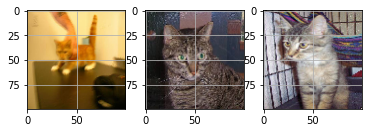

In [6]:
#image sample for cat
plt.subplot(1,3,1)
imagesample_cat=image.load_img(train + '/cats/cat.0.jpg', target_size = (100, 100)) 
plt.imshow(imagesample_cat)
plt.grid(None) 
plt.subplot(1,3,2)
imagesample_cat=image.load_img(train + '/cats/cat.1.jpg', target_size = (100, 100)) 
plt.imshow(imagesample_cat)
plt.grid(None) 
plt.subplot(1,3,3)
imagesample_cat=image.load_img(train + '/cats/cat.2.jpg', target_size = (100, 100)) 
plt.imshow(imagesample_cat)
plt.grid(None) 
plt.show()

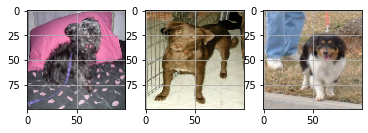

In [7]:
#image sample for dog
plt.subplot(1,3,1)
imagesample_dog=image.load_img(train + '/dogs/dog.0.jpg', target_size = (100, 100)) 
plt.imshow(imagesample_dog)
plt.grid(None) 
plt.subplot(1,3,2)
imagesample_dog=image.load_img(train + '/dogs/dog.1.jpg', target_size = (100, 100)) 
plt.imshow(imagesample_dog)
plt.grid(None) 
plt.subplot(1,3,3)
imagesample_dog=image.load_img(train + '/dogs/dog.2.jpg', target_size = (100, 100)) 
plt.imshow(imagesample_dog)
plt.grid(None) 
plt.show()

In [8]:
#transfer image to digit
#data_generator=ImageDataGenerator(rescale=1/255,zoom_range=0.2)
data_generator=ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size=32

training=data_generator.flow_from_directory(directory=train,
                                                   target_size=(224, 224),
                                                   batch_size=batch_size,
                                                   color_mode='rgb',
                                                   class_mode='binary')
testing=data_generator.flow_from_directory(directory=test,
                                                  target_size=(224, 224),
                                                  batch_size=batch_size,
                                                  color_mode='rgb',
                                                  class_mode='binary',
                                                  shuffle=False)

Found 14000 images belonging to 2 classes.
Found 6000 images belonging to 2 classes.


### Building Model

#### Pretrained Model: VGG16 (Transfer Learning)

In [9]:
#VGG16 model
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=training.image_shape)

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

conv_base.trainable = False

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 21,137,729
Trainable params: 6,423,041
Non-trainable params: 14,714,688
_________________________________________________________________


In [11]:
#time count:starttime
start = datetime.datetime.now()

#fit model with training data
fit1 = model.fit_generator(training,
                        steps_per_epoch = 300,
                        epochs = 20,
                        validation_data = testing,
                        validation_steps = 300)

#time count:endtime
end= datetime.datetime.now()
elapsed= end-start
#print ('running time:', elapsed)


Instructions for updating:
Use tf.cast instead.
Epoch 1/20
300/300 [==============================] - 73s 245ms/step - loss: 0.5524 - acc: 0.9329 - val_loss: 0.1168 - val_acc: 0.9726
Epoch 2/20
300/300 [==============================] - 71s 236ms/step - loss: 0.2102 - acc: 0.9741 - val_loss: 0.2026 - val_acc: 0.9747
Epoch 3/20
300/300 [==============================] - 71s 236ms/step - loss: 0.1385 - acc: 0.9829 - val_loss: 0.0042 - val_acc: 0.9747
Epoch 4/20
300/300 [==============================] - 71s 237ms/step - loss: 0.0968 - acc: 0.9889 - val_loss: 0.5452 - val_acc: 0.9778
Epoch 5/20
300/300 [==============================] - 71s 237ms/step - loss: 0.0861 - acc: 0.9890 - val_loss: 1.3225e-07 - val_acc: 0.9792
Epoch 6/20
300/300 [==============================] - 71s 236ms/step - loss: 0.0628 - acc: 0.9920 - val_loss: 1.1921e-07 - val_acc: 0.9723
Epoch 7/20
300/300 [==============================] - 71s 237ms/step - loss: 0.0466 - acc: 0.9939 - val_loss: 2.0781e-05 - val_acc: 0.

In [12]:
print ('running time:', elapsed)


running time: 0:23:47.407849


In [13]:
val_loss, val_acc = \
model.evaluate_generator(testing)

print('val_loss:', val_loss)
print('val_acc:', val_acc)

val_loss: 0.26308077573776245
val_acc: 0.9818333387374878


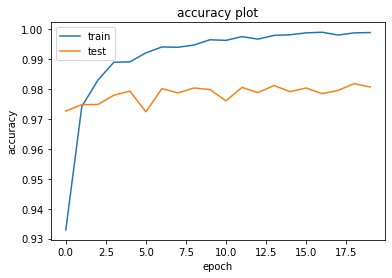

In [14]:
#accuracy plot
plt.title('accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.plot(fit1.history['acc'])
plt.plot(fit1.history['val_acc'])
plt.legend(['train', 'test'], loc='upper left')

plt.show()

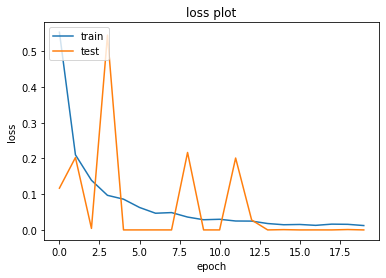

In [15]:
#loss plot
plt.title('loss plot')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(fit1.history['loss'])
plt.plot(fit1.history['val_loss'])
plt.legend(['train', 'test'], loc='upper left')

plt.show()